In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [2]:
import pickle # save images
import time # get time stamp of models trained

import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

In [ ]:
# bird_orders = pd.read_csv('data/eBird-Clements-v2019-integrated-checklist-August-2019.csv', encoding = "ISO-8859-1", error_bad_lines=False)

In [ ]:
# bird_orders.head()

# bird_orders.columns = ['eBird_code', 'order_num', 'category', 'txt_labels',
#        'sci_name', 'range', 'order', 'family', 'species_group',
#        'extinct', 'extinct_year']

# bird_orders.head(1)

# bird_orders[bird_orders['txt_labels'] == 'Harlequin Duck']

# bird_orders['order'].unique()

In [ ]:
# master_df = pd.read_csv('data/master_df.csv', index_col=0)

In [ ]:
# import re

# master_df['txt_labels'] = master_df['txt_labels'].str.replace(r'\([\s\S]*\)', '').str.strip()

In [ ]:
# orders = bird_orders[['order','txt_labels', 'family', 'species_group']].copy()

# orders.info()

# orders['order'].nunique()

# master_df.info()

# orders_df = master_df.merge(orders, on='txt_labels')

# orders_df['family'].nunique()

# orders_df['species_group'].nunique()

In [ ]:
# orders_df.to_csv('data/orders_df.csv')

## Read in final csv

In [3]:
orders_df = pd.read_csv('data/orders_df.csv', index_col=0)

In [4]:
orders_df.head(2)

,file_path,img_name,class_id,txt_labels,order,family,species_group
0,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817,Oak Titmouse,Passeriformes,"Paridae (Tits, Chickadees, and Titmice)","Tits, Chickadees, and Titmice"
1,0817/01a472d8e93047a080aae4f958a2ef47.jpg,01a472d8-e930-47a0-80aa-e4f958a2ef47,817,Oak Titmouse,Passeriformes,"Paridae (Tits, Chickadees, and Titmice)","Tits, Chickadees, and Titmice"


In [5]:
orders_df['order'].nunique()

20

In [6]:
len(orders_df)

48271

In [7]:
sum(orders_df['order'].isnull())

0

In [8]:
orders_df['species_group'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            48261, 48262, 48263, 48264, 48265, 48266, 48267, 48268, 48269,
            48270],
           dtype='int64', length=48271)

In [10]:
orders_df['family'].unique()

array(['Paridae (Tits, Chickadees, and Titmice)',
       'Parulidae (New World Warblers)',
       'Passerellidae (New World Sparrows)', 'Podicipedidae (Grebes)',
       'Tyrannidae (Tyrant Flycatchers)',
       'Ardeidae (Herons, Egrets, and Bitterns)',
       'Corvidae (Crows, Jays, and Magpies)',
       'Icteridae (Troupials and Allies)',
       'Laridae (Gulls, Terns, and Skimmers)',
       'Turdidae (Thrushes and Allies)',
       'Anatidae (Ducks, Geese, and Waterfowl)',
       'Cardinalidae (Cardinals and Allies)',
       'Accipitridae (Hawks, Eagles, and Kites)',
       'Vireonidae (Vireos, Shrike-Babblers, and Erpornis)',
       'Picidae (Woodpeckers)', 'Trochilidae (Hummingbirds)',
       'Phalacrocoracidae (Cormorants and Shags)',
       'Remizidae (Penduline-Tits)',
       'Charadriidae (Plovers and Lapwings)',
       'Fringillidae (Finches, Euphonias, and Allies)',
       'Scolopacidae (Sandpipers and Allies)',
       'Columbidae (Pigeons and Doves)', 'Strigidae (Owls)',
   

### previously [:21129]
### current: [:23555]

In [29]:
orders_df[21128:21130]

,file_path,img_name,class_id,txt_labels,order,family,species_group
21128,0934/fe76ffde47ed46ddb4687b59a6cdb0eb.jpg,fe76ffde-47ed-46dd-b468-7b59a6cdb0eb,934,Western Kingbird,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies"
21129,0501/0113a9878a344e43a2f29ce6cbbd196b.jpg,0113a987-8a34-4e43-a2f2-9ce6cbbd196b,501,American Coot,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)","Rails, Gallinules, and Allies"


In [36]:
orders_df[:21129].groupby('species_group').count()

,file_path,img_name,class_id,txt_labels,order,family
species_group,,,,,,
Alcids,196,196,196,196,196,196
Blackbirds,1587,1587,1587,1587,1587,1587
"Cardinals, Grosbeaks, and Allies",1219,1219,1219,1219,1219,1219
"Catbirds, Mockingbirds, and Thrashers",198,198,198,198,198,198
Cormorants and Anhingas,447,447,447,447,447,447
Cuckoos,230,230,230,230,230,230
Falcons and Caracaras,446,446,446,446,446,446
"Finches, Euphonias, and Allies",934,934,934,934,934,934
Grebes,253,253,253,253,253,253


In [20]:
np.unique(orders_df['species_group'])

array(['Alcids', 'Blackbirds', 'Cardinals, Grosbeaks, and Allies',
       'Catbirds, Mockingbirds, and Thrashers', 'Cormorants and Anhingas',
       'Cranes', 'Cuckoos', 'Dippers', 'Falcons and Caracaras',
       'Finches, Euphonias, and Allies',
       'Frigatebirds, Boobies, and Gannets', 'Gnatcatchers', 'Grebes',
       'Grouse, Quail, and Allies', 'Gulls, Terns, and Skimmers',
       'Herons, Ibis, and Allies', 'Hummingbirds',
       'Jays, Magpies, Crows, and Ravens', 'Kingfishers', 'Kinglets',
       'Larks', 'Long-tailed Tits and Bushtit',
       'Longspurs and Snow Buntings', 'Loons', 'Martins and Swallows',
       'New World Sparrows', 'Nightjars', 'Nuthatches',
       'Old World Sparrows', 'Owls', 'Parrotbills, Wrentit, and Allies',
       'Parrots, Parakeets, and Allies', 'Pelicans',
       'Penduline-Tits and Verdin', 'Pigeons and Doves',
       'Rails, Gallinules, and Allies', 'Shorebirds', 'Shrikes',
       'Silky-flycatchers', 'Starlings and Mynas', 'Storks', 'Swifts',
 

In [21]:
np.array(orders_df['species_group'].values)

array(['Tits, Chickadees, and Titmice', 'Tits, Chickadees, and Titmice',
       'Tits, Chickadees, and Titmice', ..., 'Vireos', 'Vireos', 'Vireos'],
      dtype=object)

In [22]:
(np.array(orders_df['species_group'].values).reshape(-1,1) == np.unique(orders_df['species_group'])).astype(float)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

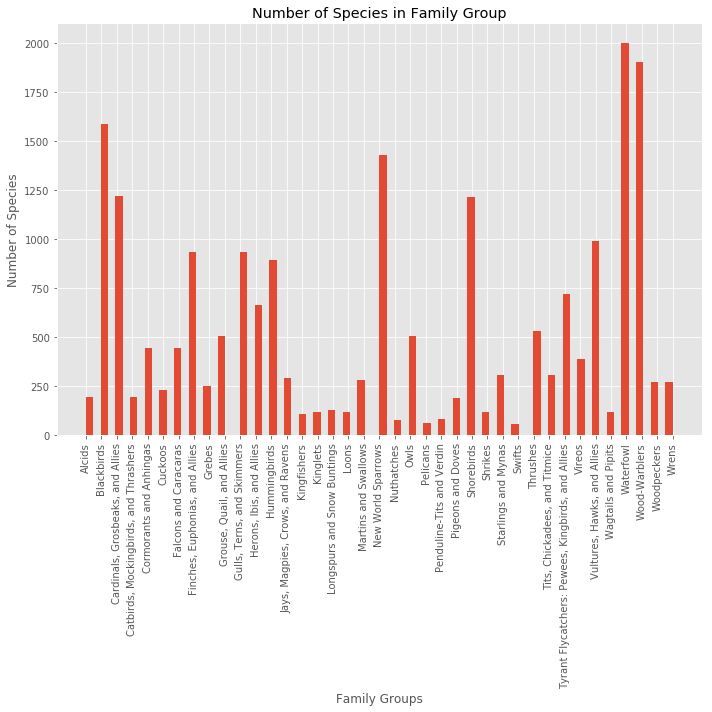

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

ax = orders_df['species_group'][:21129].hist(bins=80);
plt.xticks(rotation=90);
ax.set_title('Number of Species in Family Group')
ax.set_xlabel('Family Groups')
ax.set_ylabel('Number of Species')

plt.tight_layout()

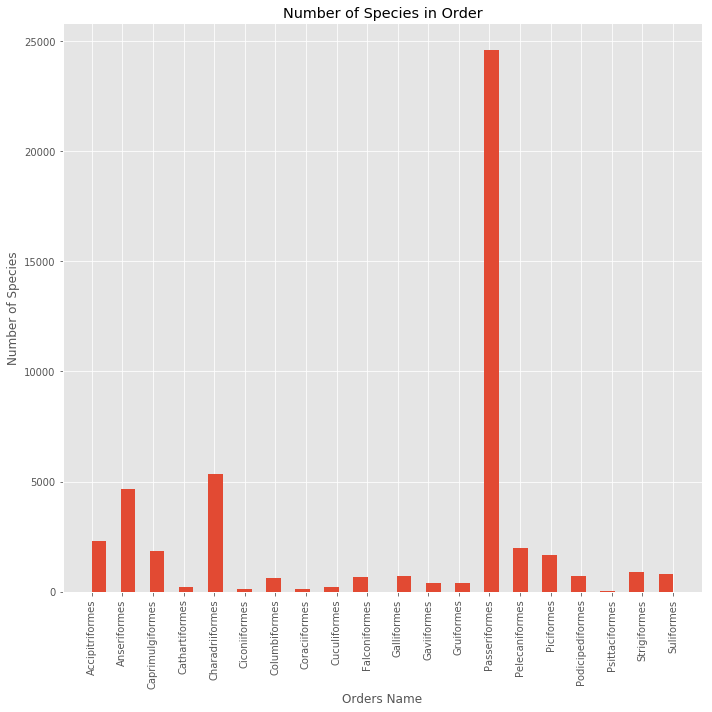

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

ax = orders_df['order'][:21129].hist(bins=40);
plt.xticks(rotation=90);
ax.set_title('Number of Species in Order')
ax.set_xlabel('Orders Name')
ax.set_ylabel('Number of Species')

plt.tight_layout()

In [25]:
img_dir = 'images' # folder containing all other folders of images
paths = orders_df['file_path']
bucket = 'cwbirdsimages'

def resize_images_array(img_dir, file_paths):
    # arrays of image pixels
    img_arrays = []
    
    paths = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for path in tqdm(file_paths):
        s3 = boto3.client('s3')
        try:
            obj = s3.get_object(Bucket=bucket, Key=f'{img_dir}/{path}')
            img_bytes = BytesIO(obj['Body'].read())
            open_img = Image.open(img_bytes)
            arr = np.array(open_img.resize((299,299))) # resize to 200,200. possible to play around with better or worse resolution
            img_arrays.append(arr)
            paths.append(path)
        except:
#             print(path) # get file_path of ones that fail to load
            continue
    return np.array(img_arrays)

In [26]:
# X = resize_images_array(img_dir, orders_df['file_path'][:21129])

In [ ]:
print('length of sample: ', len(X))
X.shape

In [ ]:
# normalize the RBG values
X = X/255.0

In [ ]:
# grab numeric label
# VALUES MUST BE NP.ARRAYS

label = np.array(orders_df['order'][:21129].values)

In [ ]:
label

In [ ]:
# labels are alphabetical
y = (label.reshape(-1,1) == np.unique(orders_df['order'][:21129])).astype(float)

In [ ]:
y[0]

In [ ]:
print('label shape: ', y.shape)
print('features shape: ', X.shape)

In [ ]:
n_categories = y.shape[1]

In [ ]:
n_categories

## Transfer Learning

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization # CNN
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import datetime

tf.__version__

'2.2.0'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

In [ ]:
log_xcept = os.path.join("logs/orders_xception", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_xcept, histogram_freq=1)

In [ ]:
input_size = (299,299,3)

In [ ]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [ ]:
transfer_model = create_transfer_model((299,299,3),n_categories)

In [ ]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [ ]:
_ = change_trainable_layers(transfer_model, 132)

In [ ]:
# print_model_properties(transfer_model, 130)

In [ ]:
transfer_model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xception_final = transfer_model.fit(X, y, batch_size=1000, epochs=5, validation_split=0.1, callbacks=[tensorboard_callback])

In [18]:
# transfer_model.save('saved_models/orders_xception.h5')
try:
    species_xception = tf.keras.models.load_model('saved_models/species_xception.h5')
except:
    pass

In [40]:
species_xception.

TypeError: 'list' object is not callable

In [ ]:
file = 'static/images/meet_duck.png'
a = Image.open(file)
c = np.array(a.resize((299,299)))

In [ ]:
ans = orders_xception.predict(c.reshape(1,299,299,3))

In [ ]:
ans

In [ ]:
np.round(ans * 100, 1)[0].argsort()[-1:-4:-1]

In [ ]:
np.unique(label)

In [28]:
# %reload_ext tensorboard

# %tensorboard --logdir='logs/orders_xception/'

In [16]:
# # graphs
# fig, ax = plt.subplots(2, 1, 1, figsize=(8, 8))
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')
# plt.savefig('graphs/mobilenet_acc.png')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.savefig('graphs/mobilenet_loss.png')